In [229]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
import re
import string
import inspect
import os
import datetime
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score,precision_recall_curve

from lightgbm import LGBMClassifier
from imblearn.over_sampling import *
from sklearn.metrics import confusion_matrix

from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler 

In [230]:
import json
import pickle
import joblib
import pandas as pd
from flask import Flask, jsonify, request
from peewee import (
    SqliteDatabase, PostgresqlDatabase, Model, IntegerField,
    FloatField, TextField, IntegrityError
)


from playhouse.shortcuts import model_to_dict
from playhouse.db_url import connect

import requests
from numpy import nan
import numpy as np
from transformers import transf as tf

In [231]:
columns = ['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
        'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'station']


# Group feaatures 
categorical_features = ['Officer-defined ethnicity','Gender','Age range','Object of search', 'station' ]#,'station''Type',','station'
numeric_features = ['Time (sin)','Time (cos)', 'Latitude','Longitude'] #'Time (sin)','Time (cos)',

In [232]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

standard_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [233]:
target_pipe =  Pipeline(
    steps=[
            ('Filter Metropolitain', tf.Filter_ColumnValue(col='station', value='metropolitan')),
            ('FixNA_OutcomeLinkedSearch', tf.FixNA_OutcomeLinkedSearch()), 
            ('OutcomePositive', tf.Mask_OutcomePositive()),
            ('SearchSuccess', tf.Mask_SearchSuccess()),
            ])

In [234]:
initial_pipe = Pipeline(
    steps=[
            ('Filter Metropolitain', tf.Filter_ColumnValue(col='station', value='metropolitan')),
            ('FixNA_Coordinates', tf.FixNA_Coordinates()),
            ('DateTransformer', tf.DateTransformer())
            ])

prep_pipeline = Pipeline([
        ('Initial Preprocessing Pipeline',initial_pipe),
        ('preprocessor', standard_preprocessor)
]    
)


pipeline_baseline_fase1 = Pipeline([
        ('Initial Preprocessing Pipeline',initial_pipe),
        ('preprocessor', standard_preprocessor),   
        ('model', LGBMClassifier(n_jobs=-1,  random_state=42
        )) 
]    
)

pipeline = Pipeline([
        ('Initial Preprocessing Pipeline',initial_pipe),
        ('preprocessor', standard_preprocessor),   
        ('model', LGBMClassifier(n_jobs=-1, class_weight={0:0.35,1:0.65} , random_state=42,learning_rate=0.10, n_estimators=40, num_leaves=40, max_depth=15, min_child_samples=40
        )) #boosting_type='dart', class_weight="balanced",class_weight={0:0.25,1:0.75}
]    
)

In [235]:
def verify_retrieve_rates(X_test, y_true, y_test, sensitive_column, max_diff= 0.10):

    sensitive_column = sensitive_column
    max_diff = max_diff
    sensitive_classes = X_test[sensitive_column].unique()

    precisions={}
    for value in sensitive_classes:
        mask = X_test[sensitive_column] == value
        precisions[value]=recall_score(y_true[mask], y_test[mask], pos_label=True)
    rate_diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
    if rate_diff > max_diff:
        return False, rate_diff,  precisions
    else:
        return True, rate_diff,  precisions

In [236]:
def plot_roc_curve(roc_auc, fpr, tpr):
    # Function to plot ROC Curve
    # Note: this is ALL just matplotlib stuff, nothing scientific about it! 
    
    # Inputs: 
    #     roc_auc - AU ROC value (float)
    #     fpr - false positive rate (output of roc_curve()) array
    #     tpr - true positive rate (output of roc_curve()) array
    
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (AUROC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='random')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [237]:
# train
df = pd.read_csv('data/train.csv')
df.head(2)

target = 'search_success'
df_train_sorted = df.sort_values(by="Date")
# print(len(df_train_sorted))
df_train_base = df_train_sorted.copy()
# df_train_base = df_train_sorted[df_train_sorted.station.isin(['cambridgeshire','city-of-london','durham','nottinghamshire'])]
# print(len(df_train_base))

# test set 1
X_test_data = pd.read_csv('data/X_test_1.csv').drop(columns=['Self-defined ethnicity'])
y_test_data = pd.read_csv('data/y_test_1.csv')

df_test_for_train = X_test_data.merge(y_test_data, on='observation_id')
df_train_base = df_train_base.append(df_test_for_train, ignore_index=True)

#
df_train, df_test = train_test_split(df_train_base,shuffle=False, test_size=0.25) 

# Baseline from fase 1 with the new data -almost like random

precision 0.26785714285714285
recall 0.0010398613518197574
f1 0.0020716801325875284
roc_auc 0.5002115811730293
Officer-defined ethnicity (True, 0.0017123287671232876, {'White': 0.0010520778537611783, 'Black': 0.0007077140835102619, 'Asian': 0.0017123287671232876, 'Other': 0.0, 'Mixed': 0.0})
Gender (True, 0.0011505714504870753, {'Male': 0.0011505714504870753, 'Female': 0.0, 'Other': 0.0})
Stations (True, 0.07017543859649122, {'dyfed-powys': 0.0, 'sussex': 0.0, 'devon-and-cornwall': 0.0, 'essex': 0.0, 'lancashire': 0.0, 'north-wales': 0.0, 'leicestershire': 0.0, 'suffolk': 0.0, 'west-mercia': 0.0, 'lincolnshire': 0.0, 'kent': 0.0, 'hampshire': 0.0, 'west-yorkshire': 0.0, 'south-yorkshire': 0.0, 'cheshire': 0.0033222591362126247, 'avon-and-somerset': 0.0, 'northumbria': 0.0, 'warwickshire': 0.0, 'thames-valley': 0.0, 'merseyside': 0.0, 'hertfordshire': 0.0, 'durham': 0.07017543859649122, 'cleveland': 0.0, 'staffordshire': 0.0, 'city-of-london': 0.0, 'cumbria': 0.0, 'bedfordshire': 0.0, '

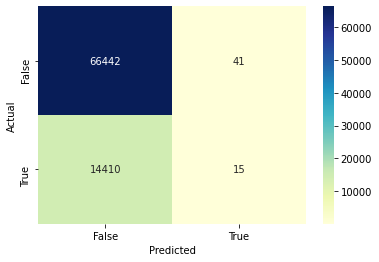

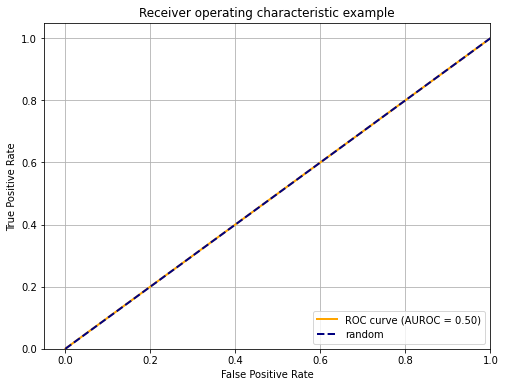

In [238]:
## 1
# Baseline from fase 1
df_train, df_test = train_test_split(df_train_base,shuffle=False, test_size=0.25) 
#train
df_train = df_train.sort_values(by="Date").copy()
df_train  = target_pipe.fit_transform(df_train)
df_test = df_test.sort_values(by="Date").copy()
df_test  = target_pipe.fit_transform(df_test)

X_train = df_train[columns]
y_train = df_train['search_success']
X_test = df_test[columns]
y_test = df_test['search_success']


pipeline_baseline_fase1.fit(X_train, y_train)


y_pred = pipeline_baseline_fase1.predict(X_test)
y_pred_proba = pipeline_baseline_fase1.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve( y_test, y_pred , pos_label=True)

from sklearn.metrics import recall_score
precision_ = precision[:-1][1]
recall_ = recall[:-1][1]
print("precision", precision_)
print("recall", recall_)
print('f1', f1_score( y_test, y_pred, pos_label=True))
print('roc_auc', roc_auc_score(y_test, y_pred))

print('Officer-defined ethnicity', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Officer-defined ethnicity', max_diff = 0.10))
print('Gender', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Gender', max_diff = 0.10))
print('Stations', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='station', max_diff = 0.10))

X_test['combine_stations'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Age range']+' ' + X_test['station']
X_test['combine'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Gender']
print('Combine', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='combine', max_diff = 0.10))

X_test['object_diff'] = X_test['Object of search'] 
print('Objectives', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='object_diff', max_diff = 0.10))

%matplotlib inline
import seaborn as sns
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt="2")

roc_auc_score_ = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve( y_test, y_pred , pos_label=True)
plot_roc_curve(roc_auc_score_, fpr, tpr)

# Baseline model with 10% threshold pred prob

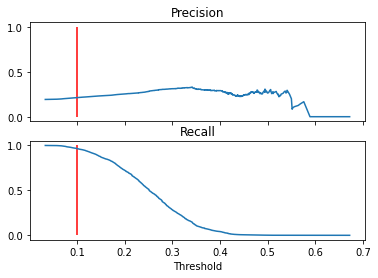

precision 0.19214986143679386
recall 0.999792027729636
f1 0.34982984441123655
roc_auc 0.6824391307236879
Officer-defined ethnicity (True, 0.03785488958990535, {'White': 0.96422935297212, 'Black': 0.967445152158528, 'Asian': 0.9743150684931506, 'Other': 0.9621451104100947, 'Mixed': 1.0})
Gender (True, 0.036231884057971064, {'Male': 0.965789675538851, 'Female': 0.9637681159420289, 'Other': 1.0})
Stations (False, 1.0, {'dyfed-powys': 0.0, 'sussex': 0.9375, 'devon-and-cornwall': 0.9765395894428153, 'essex': 0.9894339622641509, 'lancashire': 0.0, 'north-wales': 0.8089430894308943, 'leicestershire': 0.8172043010752689, 'suffolk': 0.9792746113989638, 'west-mercia': 0.9956043956043956, 'lincolnshire': 0.9354838709677419, 'kent': 0.9728395061728395, 'hampshire': 0.9810126582278481, 'west-yorkshire': 0.9794608472400513, 'south-yorkshire': 0.9386617100371747, 'cheshire': 0.9833887043189369, 'avon-and-somerset': 0.9860869565217392, 'northumbria': 1.0, 'warwickshire': 0.983739837398374, 'thames-val

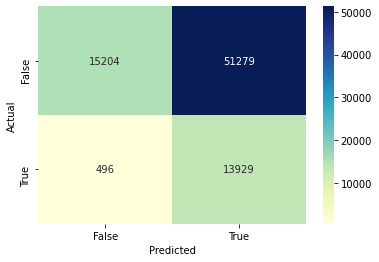

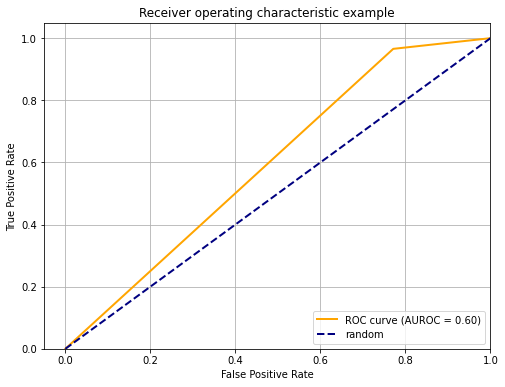

In [291]:
# Baseline from fase 1
## 2

df_train, df_test = train_test_split(df_train_base,shuffle=False, test_size=0.25) 
#train
df_train = df_train.sort_values(by="Date").copy()
df_train  = target_pipe.fit_transform(df_train)
df_test = df_test.sort_values(by="Date").copy()
df_test  = target_pipe.fit_transform(df_test)

X_train = df_train[columns]
y_train = df_train['search_success']
X_test = df_test[columns]
y_test = df_test['search_success']


pipeline_baseline_fase1.fit(X_train, y_train)

y_pred_proba = pipeline_baseline_fase1.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba>=0.10,True,False)

# y_test = np.where(y_test==True,1,0)
precision, recall, thresholds = precision_recall_curve( y_test, y_pred_proba, pos_label=True)

############################################
precision_1 = precision[:-1]
recall_1 = recall[:-1]

fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.vlines(x=0.1,ymin=0,ymax=1, colors='red')
ax1.plot(thresholds,precision_1)
ax2.plot(thresholds,recall_1)
ax2.vlines(x=0.1,ymin=0, ymax=1, colors='red')
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.show()
############################################

precision_ = precision[:-1][1]
recall_ = recall[:-1][1]
print("precision", precision_)
print("recall", recall_)
print('f1', f1_score( y_test, y_pred, pos_label=True))
print('roc_auc', roc_auc_score(y_test, y_pred_proba))

print('Officer-defined ethnicity', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Officer-defined ethnicity', max_diff = 0.05))
print('Gender', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Gender', max_diff = 0.05))
print('Stations', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='station', max_diff = 0.10))

X_test['combine_stations'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Age range']+' ' + X_test['station']
X_test['combine'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Gender']
print('Combine', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='combine', max_diff = 0.10))

X_test['object_diff'] = X_test['Object of search'] 
print('Objectives', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='object_diff', max_diff = 0.10))

%matplotlib inline
import seaborn as sns
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt="2")

roc_auc_score_ = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve( y_test, y_pred , pos_label=True)
plot_roc_curve(roc_auc_score_, fpr, tpr)

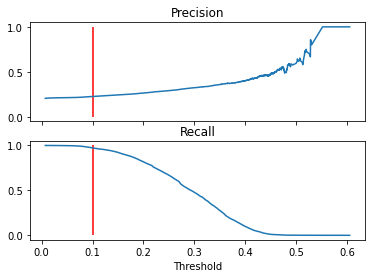

precision 0.2042489456466044
recall 0.9999356789091143
f1 0.3655157406064123
roc_auc 0.5722319763702846
Officer-defined ethnicity (False, 0.05851508717750753, {'White': 0.9729995090819833, 'Black': 0.9684711481261155, 'Asian': 0.9740048740861088, 'Other': 0.9777070063694268, 'Mixed': 0.9191919191919192})
Gender (False, 0.05494505494505486, {'Male': 0.9717999715868731, 'Female': 0.978021978021978, 'Other': 0.9230769230769231})
Stations (False, 1.0, {'sussex': 1.0, 'north-yorkshire': 0.9882352941176471, 'hampshire': 0.9910514541387024, 'west-yorkshire': 0.9910941475826972, 'thames-valley': 0.893719806763285, 'merseyside': 0.968340117593849, 'hertfordshire': 0.9738095238095238, 'leicestershire': 0.8582089552238806, 'lancashire': 0.8560606060606061, 'lincolnshire': 0.964824120603015, 'avon-and-somerset': 0.9884868421052632, 'kent': 0.9960578186596584, 'greater-manchester': 0.9473684210526315, 'surrey': 0.9848993288590604, 'cumbria': 0.9925373134328358, 'humberside': 0.0, 'devon-and-cornwal

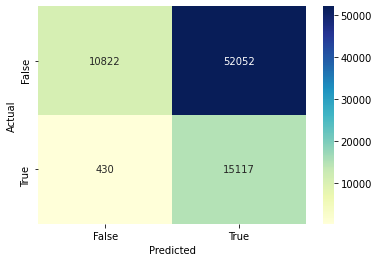

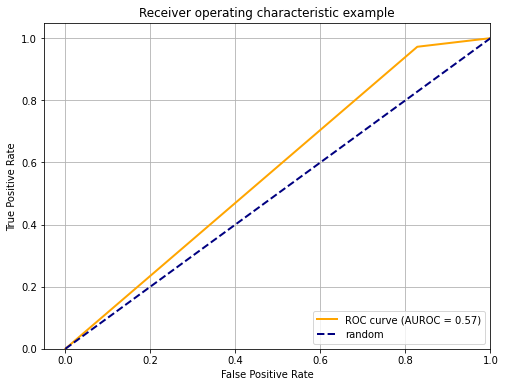

In [285]:
##3 class_weight={0:0.65,1:0.35} 
##4 class_weight={0:0.60,1:0.40} 
# Improved model with threshold

pipeline = Pipeline([
        ('Initial Preprocessing Pipeline',initial_pipe),
        ('preprocessor', standard_preprocessor),   
        ('model', LGBMClassifier(n_jobs=-1, class_weight={0:0.45,1:0.55})) #boosting_type='dart', class_weight="balanced",class_weight={0:0.25,1:0.75}
]    
)

df_train, df_test = train_test_split(df_train_base,shuffle=True, test_size=0.25) 
#train
df_train = df_train.sort_values(by="Date").copy()
df_train  = target_pipe.fit_transform(df_train)
df_test = df_test.sort_values(by="Date").copy()
df_test  = target_pipe.fit_transform(df_test)

X_train = df_train[columns]
y_train = df_train['search_success']
X_test = df_test[columns]
y_test = df_test['search_success']


pipeline.fit(X_train, y_train)

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba>0.1,True,False)

# y_test = np.where(y_test==True,1,0)
precision, recall, thresholds = precision_recall_curve( y_test, y_pred_proba, pos_label=True)

############################################
precision_1 = precision[:-1]
recall_1 = recall[:-1]

fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.vlines(x=0.1,ymin=0,ymax=1, colors='red')
ax1.plot(thresholds,precision_1)
ax2.plot(thresholds,recall_1)
ax2.vlines(x=0.1,ymin=0, ymax=1, colors='red')
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.show()
############################################

precision_ = precision[:-1][1]
recall_ = recall[:-1][1]
print("precision", precision_)
print("recall", recall_)
print('f1', f1_score( y_test, y_pred, pos_label=True))
print('roc_auc', roc_auc_score(y_test, y_pred))

print('Officer-defined ethnicity', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Officer-defined ethnicity', max_diff = 0.05))
print('Gender', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Gender', max_diff = 0.05))
print('Stations', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='station', max_diff = 0.10))

X_test['combine_stations'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Age range']+' ' + X_test['station']
X_test['combine'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Gender']
print('Combine', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='combine', max_diff = 0.10))

X_test['object_diff'] = X_test['Object of search'] 
print('Objectives', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='object_diff', max_diff = 0.10))

%matplotlib inline
import seaborn as sns
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt="2")

roc_auc_score_ = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve( y_test, y_pred , pos_label=True)
plot_roc_curve(roc_auc_score_, fpr, tpr)

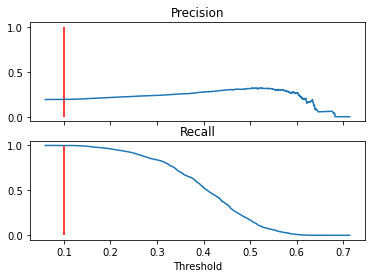

precision 0.19090475938376833
recall 0.9999306759098787
f1 0.32287467526650543
roc_auc 0.545004956245444
Officer-defined ethnicity (True, 0.0008561643835616195, {'White': 0.9993862879186393, 'Black': 1.0, 'Asian': 0.9991438356164384, 'Other': 1.0, 'Mixed': 1.0})
Gender (True, 0.0014492753623188692, {'Male': 0.9995397714198052, 'Female': 0.9985507246376811, 'Other': 1.0})
Stations (False, 1.0, {'dyfed-powys': 0.5454545454545454, 'sussex': 1.0, 'devon-and-cornwall': 1.0, 'essex': 1.0, 'lancashire': 0.0, 'north-wales': 1.0, 'leicestershire': 1.0, 'suffolk': 1.0, 'west-mercia': 1.0, 'lincolnshire': 1.0, 'kent': 1.0, 'hampshire': 1.0, 'west-yorkshire': 1.0, 'south-yorkshire': 0.9981412639405205, 'cheshire': 1.0, 'avon-and-somerset': 1.0, 'northumbria': 1.0, 'warwickshire': 1.0, 'thames-valley': 1.0, 'merseyside': 0.9995814148179154, 'hertfordshire': 1.0, 'durham': 1.0, 'cleveland': 1.0, 'staffordshire': 1.0, 'city-of-london': 1.0, 'cumbria': 1.0, 'bedfordshire': 1.0, 'surrey': 1.0, 'btp': 1

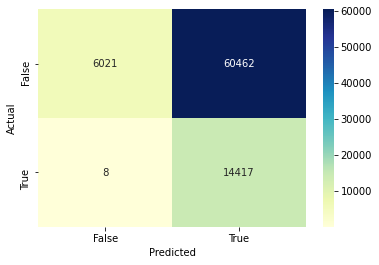

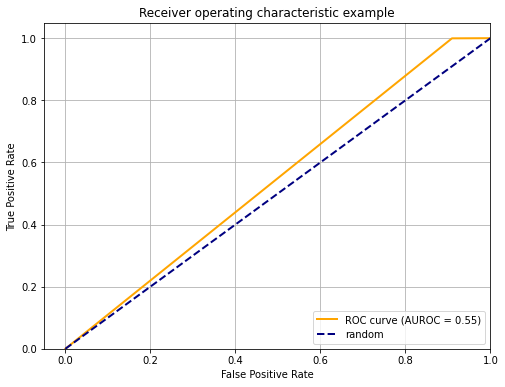

In [241]:
## 5
# Improved model 2 with threshold and undersampling

pipeline = Pipeline([
        ('Initial Preprocessing Pipeline',initial_pipe),
        ('preprocessor', standard_preprocessor),   
        ('model', LGBMClassifier(n_jobs=-1, class_weight={0:0.65,1:0.35}, random_state=42,learning_rate=0.10, n_estimators=40, num_leaves=40, max_depth=15, min_child_samples=40
        )) #boosting_type='dart', class_weight="balanced",class_weight={0:0.25,1:0.75}
]    
)

df_train, df_test = train_test_split(df_train_base, test_size=0.25,shuffle=False)#, stratify=df_train_base['station']) #,stratify=df_train_base['station'] 
#train
df_train = df_train.sort_values(by="Date").copy()
df_train  = target_pipe.fit_transform(df_train)
df_test = df_test.sort_values(by="Date").copy()
df_test  = target_pipe.fit_transform(df_test)

X_train = df_train[columns]
y_train = df_train['search_success']
X_test = df_test[columns]
y_test = df_test['search_success']

ros =  RandomUnderSampler(random_state=42) 
X_train, y_train = ros.fit_resample(X_train, y_train)
pipeline.fit(X_train, y_train)

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba>0.1,True,False)

# y_test = np.where(y_test==True,1,0)
precision, recall, thresholds = precision_recall_curve( y_test, y_pred_proba)

############################################
precision_1 = precision[:-1]
recall_1 = recall[:-1]

fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.vlines(x=0.1,ymin=0,ymax=1, colors='red')
ax1.plot(thresholds,precision_1)
ax2.plot(thresholds,recall_1)
ax2.vlines(x=0.1,ymin=0, ymax=1, colors='red')
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.show()
############################################

precision_ = precision[:-1][1]
recall_ = recall[:-1][1]
print("precision", precision_)
print("recall", recall_)
print('f1', f1_score( y_test, y_pred, pos_label=True))
print('roc_auc', roc_auc_score(y_test, y_pred))

print('Officer-defined ethnicity', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Officer-defined ethnicity', max_diff = 0.05))
print('Gender', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Gender', max_diff = 0.05))
print('Stations', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='station', max_diff = 0.10))

X_test['combine_stations'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Age range']+' ' + X_test['station']
X_test['combine'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Gender']
print('Combine', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='combine', max_diff = 0.10))

X_test['object_diff'] = X_test['Object of search'] 
print('Objectives', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='object_diff', max_diff = 0.10))

%matplotlib inline
import seaborn as sns
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt="2")

roc_auc_score_ = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve( y_test, y_pred , pos_label=True)
plot_roc_curve(roc_auc_score_, fpr, tpr)

# Under sampling - baseline fase 1 model

precision 0.254782827014813
recall 0.7035008665511265
f1 0.37408533775688874
roc_auc 0.6285204346292927
Officer-defined ethnicity (False, 0.06782351756288918, {'White': 0.7007715237594249, 'Black': 0.7062986553432413, 'Asian': 0.7157534246575342, 'Other': 0.7192429022082019, 'Mixed': 0.768595041322314})
Gender (False, 0.2028985507246377, {'Male': 0.7200276137148117, 'Female': 0.5471014492753623, 'Other': 0.75})
Stations (False, 0.9532163742690059, {'dyfed-powys': 0.0, 'sussex': 0.203125, 'devon-and-cornwall': 0.5982404692082112, 'essex': 0.8369811320754716, 'lancashire': 0.0, 'north-wales': 0.34146341463414637, 'leicestershire': 0.11827956989247312, 'suffolk': 0.616580310880829, 'west-mercia': 0.843956043956044, 'lincolnshire': 0.4774193548387097, 'kent': 0.6345679012345679, 'hampshire': 0.7822784810126582, 'west-yorkshire': 0.5853658536585366, 'south-yorkshire': 0.6059479553903345, 'cheshire': 0.8837209302325582, 'avon-and-somerset': 0.8121739130434783, 'northumbria': 0.83253588516746

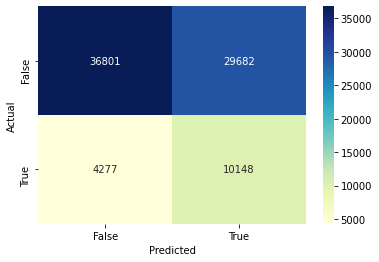

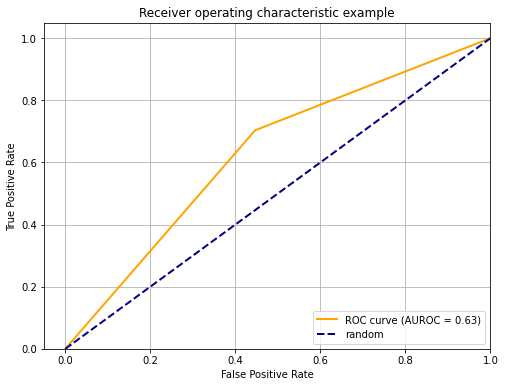

In [242]:
# under sampling baseline model no threshold
df_train, df_test = train_test_split(df_train_base, test_size=0.25, shuffle=False) #,stratify=df_train_base['station'] shuffle=True, 
#train
df_train = df_train.sort_values(by="Date").copy()
df_train  = target_pipe.fit_transform(df_train)
df_test = df_test.sort_values(by="Date").copy()
df_test  = target_pipe.fit_transform(df_test)

X_train = df_train[columns]
y_train = df_train['search_success']
X_test = df_test[columns]
y_test = df_test['search_success']

ros =  RandomUnderSampler(random_state=42) 
X_train, y_train = ros.fit_resample(X_train, y_train)
pipeline_baseline_fase1.fit(X_train, y_train)

y_pred_proba = pipeline_baseline_fase1.predict_proba(X_test)[:, 1]
y_pred = pipeline_baseline_fase1.predict(X_test)


precision, recall, thresholds = precision_recall_curve( y_test, y_pred , pos_label=True)


precision_ = precision[:-1][1]
recall_ = recall[:-1][1]
print("precision", precision_)
print("recall", recall_)
print('f1', f1_score( y_test, y_pred, pos_label=True))
print('roc_auc', roc_auc_score(y_test, y_pred))

print('Officer-defined ethnicity', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Officer-defined ethnicity', max_diff = 0.05))
print('Gender', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Gender', max_diff = 0.05))
print('Stations', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='station', max_diff = 0.10))

X_test['combine_stations'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Age range']+' ' + X_test['station']
X_test['combine'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Gender']
print('Combine', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='combine', max_diff = 0.10))

X_test['object_diff'] = X_test['Object of search'] 
print('Objectives', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='object_diff', max_diff = 0.10))

%matplotlib inline
import seaborn as sns
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt="2")

roc_auc_score_ = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve( y_test, y_pred , pos_label=True)
plot_roc_curve(roc_auc_score_, fpr, tpr)

precision 0.2554522569228085
recall 0.7105025996533796
f1 0.37579290873757926
roc_auc 0.6305923644597539
Officer-defined ethnicity (False, 0.06843770653845926, {'White': 0.7086621076626337, 'Black': 0.7084217975937721, 'Asian': 0.7148972602739726, 'Other': 0.7444794952681388, 'Mixed': 0.7768595041322314})
Gender (False, 0.16159420289855075, {'Male': 0.723402623302907, 'Female': 0.5884057971014492, 'Other': 0.75})
Stations (False, 0.9473684210526315, {'dyfed-powys': 0.0, 'sussex': 0.0625, 'devon-and-cornwall': 0.5630498533724341, 'essex': 0.8316981132075472, 'lancashire': 0.0, 'north-wales': 0.4959349593495935, 'leicestershire': 0.08602150537634409, 'suffolk': 0.8134715025906736, 'west-mercia': 0.8219780219780219, 'lincolnshire': 0.632258064516129, 'kent': 0.682716049382716, 'hampshire': 0.8139240506329114, 'west-yorkshire': 0.5661103979460848, 'south-yorkshire': 0.6561338289962825, 'cheshire': 0.8006644518272426, 'avon-and-somerset': 0.7895652173913044, 'northumbria': 0.820574162679425

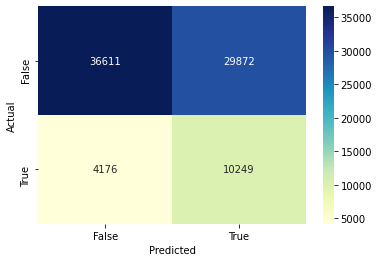

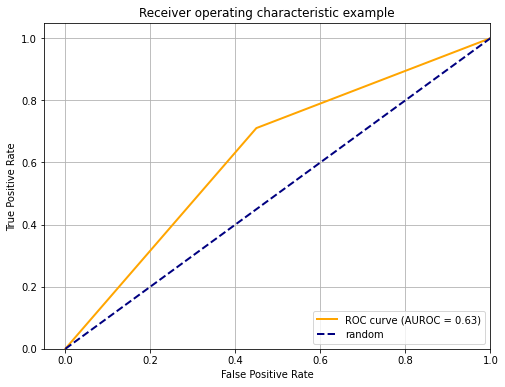

In [271]:
# Improved model no threshold no balance stratify ['Object of search']
## 11
pipeline = Pipeline([
        ('Initial Preprocessing Pipeline',initial_pipe),
        ('preprocessor', standard_preprocessor),   
        ('model', LGBMClassifier(n_jobs=-1, random_state=42,learning_rate=0.05, n_estimators=40, num_leaves=40, max_depth=15, min_child_samples=40,class_weight={0:0.50,1:0.50}
        )) #boosting_type='dart', class_weight="balanced",class_weight={0:0.25,1:0.75}
]    
)

df_train, df_test = train_test_split(df_train_base, test_size=0.25, shuffle=False) #, stratify=df_train_base['Object of search']
#train
df_train = df_train.sort_values(by="Date").copy()
df_train  = target_pipe.fit_transform(df_train)
df_test = df_test.sort_values(by="Date").copy()
df_test  = target_pipe.fit_transform(df_test)

X_train = df_train[columns]
y_train = df_train['search_success']
X_test = df_test[columns]
y_test = df_test['search_success']

ros =  RandomUnderSampler(random_state=42) 
X_train, y_train = ros.fit_resample(X_train, y_train)
pipeline.fit(X_train, y_train)

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = pipeline.predict(X_test)


precision, recall, thresholds = precision_recall_curve( y_test, y_pred , pos_label=True)


precision_ = precision[:-1][1]
recall_ = recall[:-1][1]
print("precision", precision_)
print("recall", recall_)
print('f1', f1_score( y_test, y_pred, pos_label=True))
print('roc_auc', roc_auc_score(y_test, y_pred))

print('Officer-defined ethnicity', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Officer-defined ethnicity', max_diff = 0.05))
print('Gender', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Gender', max_diff = 0.05))
print('Stations', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='station', max_diff = 0.10))

X_test['combine_stations'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Age range']+' ' + X_test['station']
X_test['combine'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Gender']
print('Combine', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='combine', max_diff = 0.10))

X_test['object_diff'] = X_test['Object of search'] 
print('Objectives', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='object_diff', max_diff = 0.10))

%matplotlib inline
import seaborn as sns
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt="2")

roc_auc_score_ = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve( y_test, y_pred , pos_label=True)
plot_roc_curve(roc_auc_score_, fpr, tpr)

precision 0.24818132951084035
recall 0.8918866709594333
f1 0.388309503784693
roc_auc 0.6130938987035783
Officer-defined ethnicity (True, 0.024325457849853183, {'White': 0.8930186662281062, 'Asian': 0.8925686591276252, 'Black': 0.8842592592592593, 'Other': 0.8938906752411575, 'Mixed': 0.8695652173913043})
Gender (True, 0.038631790744466876, {'Female': 0.895774647887324, 'Male': 0.8915295119182747, 'Other': 0.8571428571428571})
Stations (False, 1.0, {'sussex': 0.8842975206611571, 'north-yorkshire': 0.8, 'hampshire': 0.9545970488081725, 'west-yorkshire': 0.788647342995169, 'merseyside': 0.9327146171693735, 'devon-and-cornwall': 0.9705882352941176, 'hertfordshire': 0.9382093316519546, 'city-of-london': 0.8318965517241379, 'bedfordshire': 0.8772727272727273, 'leicestershire': 0.6, 'west-mercia': 0.959758551307847, 'durham': 1.0, 'lancashire': 0.8297872340425532, 'kent': 0.9088507265521797, 'btp': 0.8665447897623401, 'cumbria': 0.9285714285714286, 'staffordshire': 0.9139240506329114, 'thames

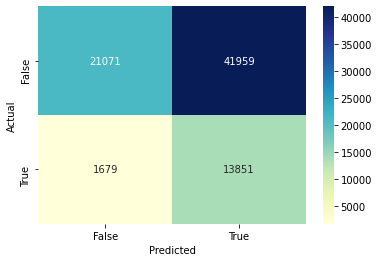

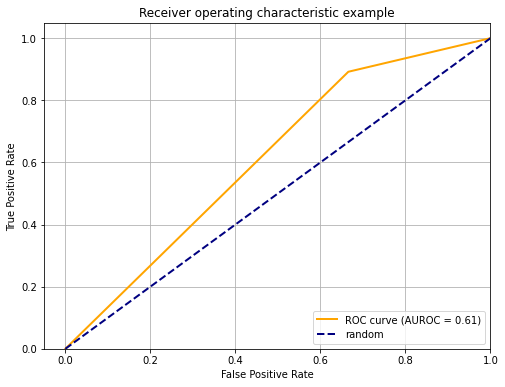

In [260]:
# Improved model 2 no threshold
##9 #
pipeline = Pipeline([
        ('Initial Preprocessing Pipeline',initial_pipe),
        ('preprocessor', standard_preprocessor),   
        ('model', LGBMClassifier(n_jobs=-1, class_weight={0:0.40,1:0.60}, random_state=42,learning_rate=0.10, n_estimators=40, num_leaves=40, max_depth=15, min_child_samples=40
        ))
]    
)

df_train, df_test = train_test_split(df_train_base, test_size=0.25, shuffle=True) #,stratify=df_train_base['station'] 
#train
df_train = df_train.sort_values(by="Date").copy()
df_train  = target_pipe.fit_transform(df_train)
df_test = df_test.sort_values(by="Date").copy()
df_test  = target_pipe.fit_transform(df_test)

X_train = df_train[columns]
y_train = df_train['search_success']
X_test = df_test[columns]
y_test = df_test['search_success']

ros =  RandomUnderSampler(random_state=42) 
X_train, y_train = ros.fit_resample(X_train, y_train)
pipeline.fit(X_train, y_train)

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = pipeline.predict(X_test)


precision, recall, thresholds = precision_recall_curve( y_test, y_pred , pos_label=True)


precision_ = precision[:-1][1]
recall_ = recall[:-1][1]
print("precision", precision_)
print("recall", recall_)
print('f1', f1_score( y_test, y_pred, pos_label=True))
print('roc_auc', roc_auc_score(y_test, y_pred))

print('Officer-defined ethnicity', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Officer-defined ethnicity', max_diff = 0.05))
print('Gender', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Gender', max_diff = 0.05))
print('Stations', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='station', max_diff = 0.10))

X_test['combine_stations'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Age range']+' ' + X_test['station']
X_test['combine'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Gender']
print('Combine', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='combine', max_diff = 0.10))

X_test['object_diff'] = X_test['Object of search'] 
print('Objectives', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='object_diff', max_diff = 0.10))

%matplotlib inline
import seaborn as sns
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt="2")

roc_auc_score_ = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve( y_test, y_pred , pos_label=True)
plot_roc_curve(roc_auc_score_, fpr, tpr)

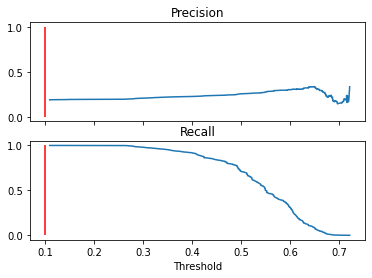

precision 0.18889965687943633
recall 0.9999306759098787
f1 0.31653555401950784
roc_auc 0.5315118150504641
Officer-defined ethnicity (True, 0.0, {'White': 1.0, 'Black': 1.0, 'Asian': 1.0, 'Other': 1.0, 'Mixed': 1.0})
Gender (True, 0.0, {'Male': 1.0, 'Female': 1.0, 'Other': 1.0})
Stations (False, 1.0, {'dyfed-powys': 1.0, 'sussex': 1.0, 'devon-and-cornwall': 1.0, 'essex': 1.0, 'lancashire': 0.0, 'north-wales': 1.0, 'leicestershire': 1.0, 'suffolk': 1.0, 'west-mercia': 1.0, 'lincolnshire': 1.0, 'kent': 1.0, 'hampshire': 1.0, 'west-yorkshire': 1.0, 'south-yorkshire': 1.0, 'cheshire': 1.0, 'avon-and-somerset': 1.0, 'northumbria': 1.0, 'warwickshire': 1.0, 'thames-valley': 1.0, 'merseyside': 1.0, 'hertfordshire': 1.0, 'durham': 1.0, 'cleveland': 1.0, 'staffordshire': 1.0, 'city-of-london': 1.0, 'cumbria': 1.0, 'bedfordshire': 1.0, 'surrey': 1.0, 'btp': 1.0, 'nottinghamshire': 1.0, 'norfolk': 1.0, 'derbyshire': 1.0, 'northamptonshire': 1.0, 'gloucestershire': 1.0, 'humberside': 0.0, 'north-yo

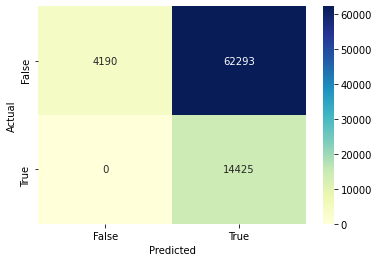

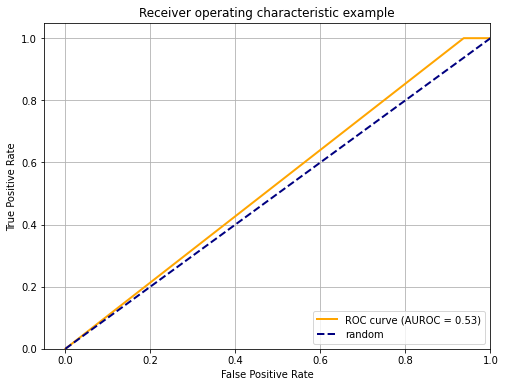

In [281]:
# Improved baseline model with threshold #
## 10
pipeline = Pipeline([
        ('Initial Preprocessing Pipeline',initial_pipe),
        ('preprocessor', standard_preprocessor),   
        ('model', LGBMClassifier(n_jobs=-1, random_state=42,learning_rate=0.05, n_estimators=40, num_leaves=40, max_depth=15, min_child_samples=40
        )) #boosting_type='dart', class_weight="balanced",class_weight={0:0.25,1:0.75}
]    
)

df_train, df_test = train_test_split(df_train_base, test_size=0.25, shuffle=False) #,stratify=df_train_base['station'] 
#train
df_train = df_train.sort_values(by="Date").copy()
df_train  = target_pipe.fit_transform(df_train)
df_test = df_test.sort_values(by="Date").copy()
df_test  = target_pipe.fit_transform(df_test)

X_train = df_train[columns]
y_train = df_train['search_success']
X_test = df_test[columns]
y_test = df_test['search_success']

ros =  RandomUnderSampler(random_state=42) 
X_train, y_train = ros.fit_resample(X_train, y_train)
pipeline.fit(X_train, y_train)

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = np.where(y_pred_proba>0.10,True,False)

# y_test = np.where(y_test==True,1,0)
precision, recall, thresholds = precision_recall_curve( y_test, y_pred_proba , pos_label=True)

############################################
precision_1 = precision[:-1]
recall_1 = recall[:-1]

fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.vlines(x=0.1,ymin=0,ymax=1, colors='red')
ax1.plot(thresholds,precision_1)
ax2.plot(thresholds,recall_1)
ax2.vlines(x=0.1,ymin=0, ymax=1, colors='red')
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.show()
############################################

precision_ = precision[:-1][1]
recall_ = recall[:-1][1]
print("precision", precision_)
print("recall", recall_)
print('f1', f1_score( y_test, y_pred, pos_label=True))
print('roc_auc', roc_auc_score(y_test, y_pred))

print('Officer-defined ethnicity', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Officer-defined ethnicity', max_diff = 0.05))
print('Gender', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='Gender', max_diff = 0.05))
print('Stations', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='station', max_diff = 0.10))

X_test['combine_stations'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Age range']+' ' + X_test['station']
X_test['combine'] = X_test['Officer-defined ethnicity'] +' ' + X_test['Gender']
print('Combine', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='combine', max_diff = 0.10))

X_test['object_diff'] = X_test['Object of search'] 
print('Objectives', verify_retrieve_rates(X_test, y_test, y_pred, sensitive_column ='object_diff', max_diff = 0.10))

%matplotlib inline
import seaborn as sns
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", fmt="2")

roc_auc_score_ = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve( y_test, y_pred , pos_label=True)
plot_roc_curve(roc_auc_score_, fpr, tpr)